<h1 style="text-align: center; color: #00308F;"> Insert Project Title  </h1>
<h2 style = "text-align: center">DSCI 100 Term Project - 2022 Winter</h2>
<h4 style = "text-align: center">Group 69: Insert Names Here</h4>

<h2><span style="text-decoration: underline;">Introduction</span></h2>

<h3 style = "color: #00308F;">Background Information</h3>

Twitch is an online streaming platform where creators can live-stream to an audience. Some of the most popular genres of streams are eSports (video games), and vlogging. Twitch has a follower system where users "follow" specific channels, this gives them notifications when the channel goes live. <br>

The dataset we are working with was compiled by Aayush Mishra [1], and consists of the top 1000 channels on Twitch in 2019. Top streamers on the platform are labeled "Partnered" if they have special recognition based on their commitment to streaming. The platform also has age-restricted streams called "Mature" for an audience that is 18+ only. <br>


We begin by installing/loading the libraries necessary for executing our project below: 

In [47]:
install.packages("plotly")
library(plotly)
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(reshape2)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We now load our data below: 

In [44]:
twitch_data <- read_csv("https://raw.githubusercontent.com/BraedenFong12/DSCI-100-Group-69/main/Dataset")
colnames(twitch_data) <- make.names(colnames(twitch_data), unique = TRUE)

head(twitch_data)

Rows: 1000 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Channel, Language
dbl (7): Watch time(Minutes), Stream time(minutes), Peak viewers, Average vi...
lgl (2): Partnered, Mature

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Channel,Watch.time.Minutes.,Stream.time.minutes.,Peak.viewers,Average.viewers,Followers,Followers.gained,Views.gained,Partnered,Mature,Language
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>
xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,TRUE,FALSE,English
summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,TRUE,FALSE,English
Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,TRUE,TRUE,Portuguese
ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,TRUE,FALSE,English
Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,TRUE,FALSE,English
Asmongold,3668799075,82260,263720,42414,1563438,554201,61715781,TRUE,FALSE,English


Here, the columns represent:

**Channel:** The name of the channel/account  
**Watch time:** sum of all the time every viewer has watched the channel (in minutes)  
**Stream time:** total time the streamer has streamed (in minutes)  
**Peak viewers:** The most number of viewers the channel ever hit  
**Average viewers:** Average number of viewers  
**Followers:** Number of current followers  
**Followers gained:** Number of followers gained in the span of one year (2019)  
**Views gained:** Number of views gained in one year  
**Partnered:** is the channel Twitch partnered  
**Mature:** 18+ Stream or not (True/False)  
**Language:** what language the stream is in

<h3 style = "color: #00308F;">Research Question</h3>

We aim to determine if the <strong> audience age, twitch partnership status, and an average number of viewers per stream affect the channel's followers </strong>. We aim to answer the question of how audience age, twitch partnership, and the average number of viewers correlate with the channel's number of followers?
We’ll use the dataset “Top Streamers on Twitch” (source: https://www.kaggle.com/datasets/aayushmishra1512/twitchdata?resource=download). The data file is “twitchdata-update.csv”.

<h3 style = "color: #00308F;">Exploratory Data Analysis</h3>

Since we are anwsering a regression question (attempting to define a mathematical relationship), we will need to filter this dataset to only contain numeric data. This process is completed in the code chunk below:

In [45]:
numeric_twitch_data <- twitch_data |>
select_if(is.numeric)

head(numeric_twitch_data)

Watch.time.Minutes.,Stream.time.minutes.,Peak.viewers,Average.viewers,Followers,Followers.gained,Views.gained
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6196161750,215250,222720,27716,3246298,1734810,93036735
6091677300,211845,310998,25610,5310163,1370184,89705964
5644590915,515280,387315,10976,1767635,1023779,102611607
3970318140,517740,300575,7714,3944850,703986,106546942
3671000070,123660,285644,29602,8938903,2068424,78998587
3668799075,82260,263720,42414,1563438,554201,61715781


In any supervised learning problem, Multicolinearity is a problem that reduces the effectiveness of the model on unseen datasets. This is because when different predictor values are strongly correlated, then tend to change in unison, and the training process has a hard time figuring out the independent contribution of each predictor to the response variable. Hence, it is good practice to replace co-linear variables with ratios between the two. [2]  <br>

To do so, we will begin by generating a correlation heatmap between all the numeric predictors present in our dataset (stored in the <strong> numeric_twitch_data</strong> variable). This process is shown below:

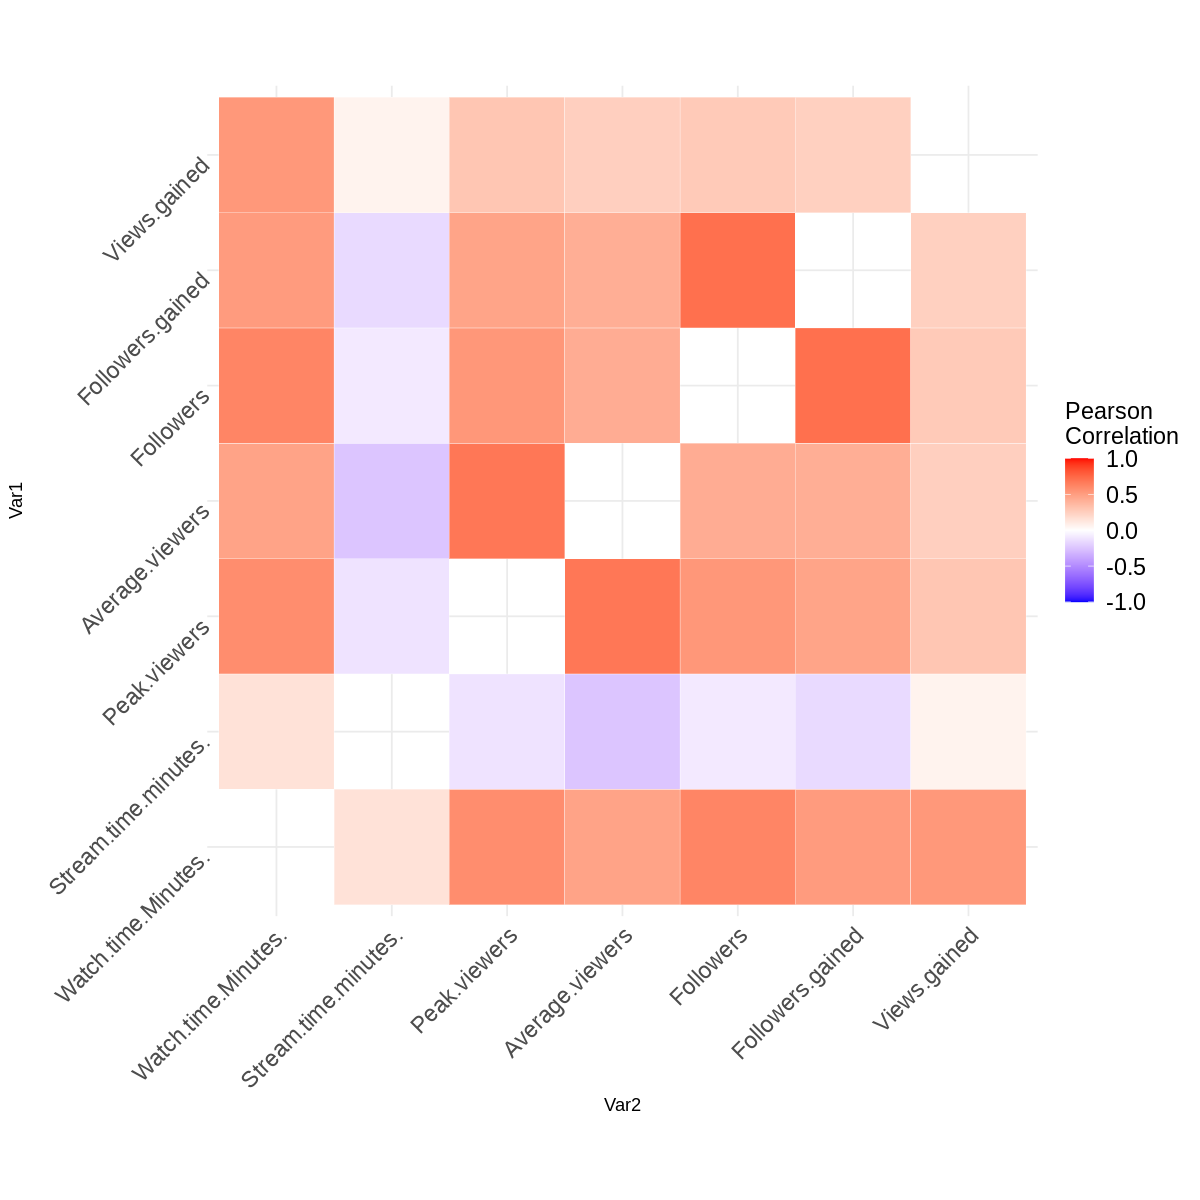

In [215]:
corMat <- cor(numeric_twitch_data) 

meltMat <- melt(corMat)

filtMat <- meltMat |>
    filter(value <1.000, value > -1.000) 

options(repr.plot.width=10, repr.plot.height=10)

  twitch_heat <- ggplot(filtMat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
 theme(axis.text = element_text(angle = 45, vjust = 1, size = 14, hjust = 1), legend.text = element_text(size = 14), legend.title= element_text(size = 14))+
 coord_fixed() 

twitch_heat


From this plot, we see that **Average.viewers Vs. Peak.viewers** and **Followers Vs. Followers.gained** are both highly correlated variables. As such, it would be beneficial to combine these features into one new feature, which would be some ratio of the two. Hence, we decided to replace both pairings with predictor variables called **Average.per.peak** and **Newfollow.per.totalfollow** <br>
<br>

Here, the new **Average.per.peak** column represents the ratio of average viewers the channels recieve over the peak number of viewers the channel ever hit. It is mathematically represented by the equation: <br>

<br>
Similiarly, the **Newfollow.per.totalfollow** column represents the ratio of new followers gained by the channel over a period of 1 year, over the total number of followers the channel has. It is mathematically represented by the equation: <br>
<br>

<h2><span style="text-decoration: underline;">Methods and Results</span></h2>

<h3 style = "color: #00308F;">Model Building and Training</h3>

<h3 style = "color: #00308F;">Model Tuning and Evaluation</h3>

<h3 style = "color: #00308F;">Results</h3>

<h2><span style="text-decoration: underline;">Discussion</span></h2>

<h3 style = "color: #00308F;">Implications of Findings</h3>

<h3 style = "color: #00308F;">Limitations and Future Works</h3>

<h2><span style="text-decoration: underline;">References</span></h2>

We can just type references in regular format; Use this "break" tag to force a new line to begin<br>
[1] Source <br>
[2] https://link.springer.com/chapter/10.1007/978-0-585-25657-3_37#:~:text=Multicollinearity%20exists%20whenever%20an%20independent,significance%20of%20an%20independent%20variable. <br>

<br> <br> <br><br><br><br><br><br><br><br><br><br><br><br><br>

<h1 style="text-align: center; color: #00308F;"> Old Stuff Below This  </h1>

<font size = "6"> Top Streamers on Twitch Regression Analysis</font>

Background information: Twitch is an online streaming platform where creators can live-stream to an audience. Some of the most popular genres of streams are eSports (video games), and vlogging. Twitch has a follower system where users "follow" specific channels, this gives them notifications when the channel goes live.  
This dataset was compiled by Aayush Mishra, and consists of the top 1000 channels on Twitch in 2019. Top streamers on the platform are labeled "Partnered" if they have special recognition based on their commitment to streaming. The platform also has age-restricted streams called "Mature" for an audience that is 18+ only.  
We aim to determine if the audience age, twitch partnership status, and an average number of viewers per stream affect the channel's followers. We aim to answer the question of how audience age, twitch partnership, and the average number of viewers correlate with the channel's number of followers?  
We’ll use the dataset “Top Streamers on Twitch” (source: https://www.kaggle.com/datasets/aayushmishra1512/twitchdata?resource=download). The data file is “twitchdata-update.csv”.


Before selecting for our predictors, the columns in the full dataset are:

**Channel:** The name of the channel/account  
**Watch time:** sum of all the time every viewer has watched the channel (in minutes)  
**Stream time:** total time the streamer has streamed (in minutes)  
**Peak viewers:** The most number of viewers the channel ever hit  
**Average viewers:** Average number of viewers  
**Followers:** Number of current followers  
**Followers gained:** Number of followers gained in the span of one year (2019)  
**Views gained:** Number of views gained in one year  
**Partnered:** is the channel Twitch partnered  
**Mature:** 18+ Stream or not (True/False)  
**Language:** what language the stream is in

,Stream.time.minutes.,Followers,Average.viewers,Watch.time.Minutes.,Peak.viewers,Followers.gained,Views.gained
Stream.time.minutes.,1.00000000,-0.09129851,-0.2492478,0.1505879,-0.1195403,-0.1581648,0.06437003
Followers,-0.09129851,1.00000000,0.4283032,0.6202339,0.5325293,0.7156185,0.27646651
Average.viewers,-0.24924779,0.42830322,1.0000000,0.4761650,0.6826373,0.4200974,0.25034887
Watch.time.Minutes.,0.15058790,0.62023388,0.4761650,1.0000000,0.5827966,0.5146476,0.52986201
Peak.viewers,-0.11954029,0.53252932,0.6826373,0.5827966,1.0000000,0.4704147,0.29806263
Followers.gained,-0.15816479,0.71561846,0.4200974,0.5146476,0.4704147,1.0000000,0.24429687
Views.gained,0.06437003,0.27646651,0.2503489,0.5298620,0.2980626,0.2442969,1.00000000


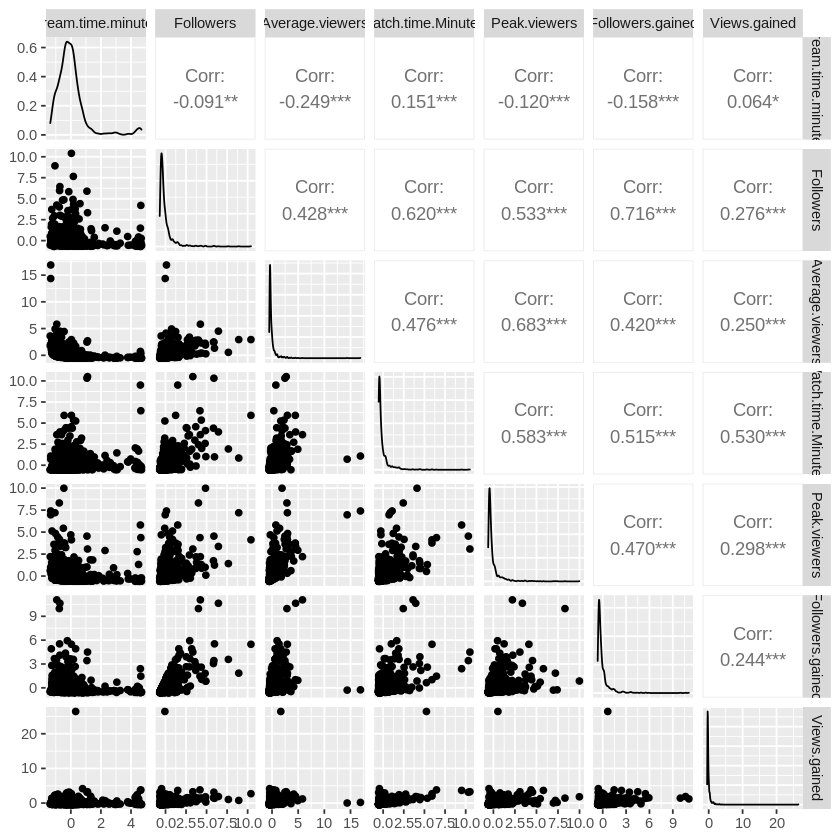

In [10]:
numeric_twitch_data <- twitch_data |>
select(Stream.time.minutes., Followers, Average.viewers, Watch.time.Minutes.,
       Peak.viewers, Followers.gained, Views.gained)



twitch_data_scaled <- scale(numeric_twitch_data)

#Visualize correlation using correlogram
graphs <- ggpairs(as.data.frame(twitch_data_scaled)) 
graphs
    
#Correlation matrix
correlations <- cor(twitch_data_scaled)
correlations


In [11]:
#Choose the predictor variable we want to work with
twitch_data <- twitch_data |>
select(Channel, Stream.time.minutes., Followers, Average.viewers)

head(twitch_data)

Channel,Stream.time.minutes.,Followers,Average.viewers
<chr>,<dbl>,<dbl>,<dbl>
xQcOW,215250,3246298,27716
summit1g,211845,5310163,25610
Gaules,515280,1767635,10976
ESL_CSGO,517740,3944850,7714
Tfue,123660,8938903,29602
Asmongold,82260,1563438,42414


<h2><center>Exploratory Data Analysis</center></h2>

Here, we split our dataset into training and testing data:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



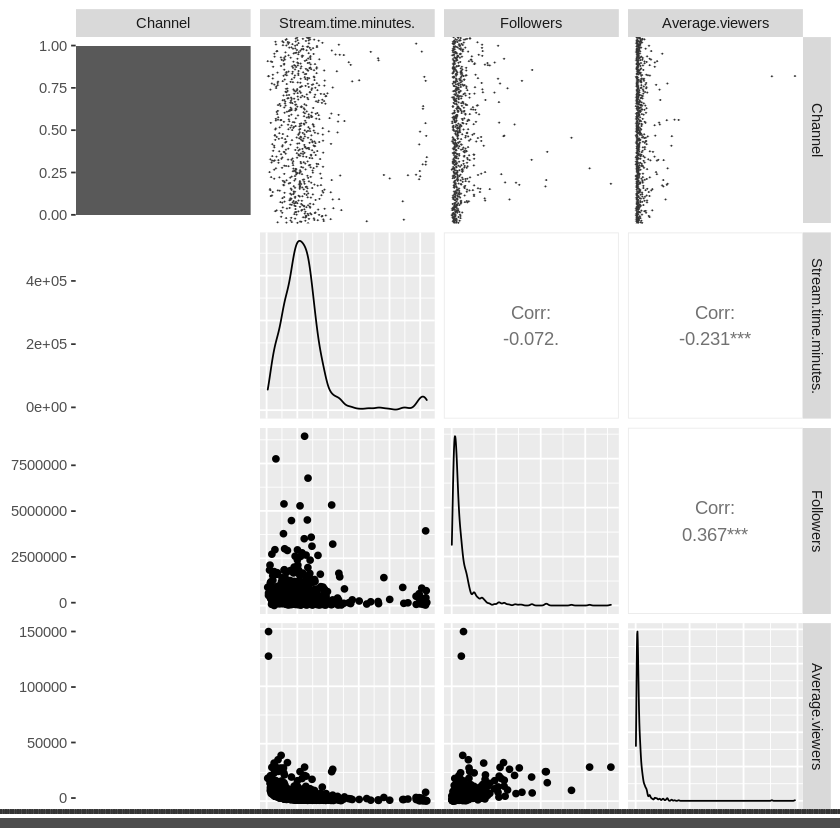

In [13]:
set.seed(2000)

twitch_split <- initial_split(twitch_data, prop = 0.70, strata = Followers)
training_data <- training(twitch_split)
testing_data <- testing(twitch_split)

graph <- ggpairs(training_data, cardinality_threshold = 1000)
graph

In this section, we find the amount of observations in each class, the mean of each variable, and the number of rows with missing data, and put this information into a table:

In [ ]:
#Calculate the mean for each variable
twitch_means <- training_data |> 
map(mean)

#Find missing data (NA)
observations_na <- training_data |> 
is.na() |>
colSums(is.na(training_data))


twitch_means
observations_na

#Total number of observations
nrow(training_data)

<h3><center>Summary of Training Dataset</center></h3>

| Class | Number of missing rows of data | Number of observations | Mean |
| --- | --- | --- | ---|
| Followers | 0 | 700 | 576751.11 |
| Stream time (minutes) | 0 | 700 | 121715.207142857 |
| Average.viewers | 0 | 700 | 4704.02571428571 |


We then made a plot to see the distribution of each variable on its own:

In [ ]:
options(repr.plot.width = 60, repr.plot.height = 40)

#Distribution of number of followers for all channels
follower_distribution <- twitch_data |>
ggplot(aes(x = Followers)) +
geom_histogram() +
theme(text = element_text(size = 80)) +
labs(x = "Number of Followers", y = "Number of Channels",
     Title = "Followers Distribution")

#Distribution of total amount of stream time for all channels
stream_time_distribution <- twitch_data |>
ggplot(aes(x = Stream.time.minutes.)) +
geom_histogram() +
theme(text = element_text(size = 80)) +
labs(x = "Stream time in minutes", y = "Number of Channels",
     Title = "Stream Time Distribution")

#Distribution of average number of viewers per stream for all channels
average.viewers_distribution <- twitch_data |>
ggplot(aes(x = Average.viewers)) +
geom_histogram() +
theme(text = element_text(size = 80)) +
labs(x = "Number of Viewers per Stream", y = "Number of Channels",
     Title = "Average Viewers Distribution")



grid.arrange(follower_distribution,stream_time_distribution, average.viewers_distribution, ncol = 2)


In the next plot, we do a preliminary scatterplot to see the distribution of our predictor variables (Average viewers and stream time) in correlation with our response variable (Followers):

In [ ]:
#Graph of average viewers vs Number of followers in our training data
viewers_vs_followers <- training_data |>
ggplot(aes(x = Followers, y = Average.viewers)) +
geom_point(size = 15, alpha = 0.6) +
theme(text = element_text(size = 80)) +
labs(x = "Average Viewers", y = "Number of Followers",
     title = "Average Viewers v.s. Followers in Training Data")
viewers_vs_followers

#Graph of total stream time vs Number of followers in our training data
stream_time_vs_followers <- training_data |>
ggplot(aes(x = Followers, y = Stream.time.minutes.)) +
geom_point(size = 15, alpha = 0.6) +
theme(text = element_text(size = 80)) +
labs(x = "Stream time (in minutes)", y = "Number of Followers",
     title = "Total stream time (minutes) v.s. Followers in Training Data")
stream_time_vs_followers

<h3><center>Methods</center></h3>

To build our regression model, we will split the training and testing sets to ensure that we assess the performance of our method on data not seen during training. We will train our model to predict the number of followers a streamer has based on if their content is mature, if they are partnered, and their average viewers per stream. We can use the K-nearest neighbors-based approach in regression to make predictions, using neighboring points to the new issue of interest to suggest/predict the number of followers. Then, we will use cross-validation to choose K (using RMSPE) and assess how well our model predicts unseen data, using the RMSPE on the unused testing data we stored away earlier. Next, we will re-train our KNN regression model on the entire training data set. Using multiple predictors in KNN regression, we will do 5-fold cross-validation to choose the number of neighbors via the minimum RMSPE.

<h3><center>Expected Outcomes and Significance</center></h3>

We believe that an audience under 18 years old, being partnered, and having higher average viewers will mean more followers on the channel. Analyzing data gathered from top streamers can help smaller streamers maximize their streaming profit. This will also help Twitch know which streamers to monetize. Larger streamers can use the data to further improve their popularity by adjusting factors that may seem minor in their content and streams. This analysis leads to future questions including, which factor has more effect on a channel's revenue, the amount of followers or amount of average viewers?

In [ ]:
#Multivariable linear regression process

#Create a recipe with Number of followers as the response variable and the predictor variables being average 
#viewers and stream time in minutes using the training data
lin_recipe <- recipe(Followers~Average.viewers + Stream.time.minutes., data = training_data)
lin_recipe

#Create a specification for linear regression
lin_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

#Create a workflow combining the recipe and specification
lin_fit <- workflow() |>
  add_recipe(lin_recipe) |>
  add_model(lin_spec) |>
  fit(data = training_data)
lin_fit


lin_test_results <- lin_fit |>
  predict(testing_data) |>
  bind_cols(testing_data) |>
  metrics(truth = Followers, estimate = .pred)

lin_test_results


# Calculate the rmse value
lin_rmspe <- lin_test_results |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

#Plot for average viewers vs number of followers with the linear regression line fitted
lin_plot_average_viewers <- ggplot(training_data, aes(x = Average.viewers, y = Followers)) +
  geom_point(size = 8, alpha = 0.6) +
  xlab("Average viewers ") +
  ylab("Followers") +
  scale_y_continuous(labels = dollar_format()) +
  theme(text = element_text(size = 80)) +
  geom_smooth(method = "lm", size = 4, se = FALSE)
lin_plot_average_viewers 

#Plot for stream time vs number of followers with the linear regression line fitted
lin_plot_stream_time <- ggplot(training_data, aes(x = Stream.time.minutes., y = Followers)) +
  geom_point(size = 8, alpha = 0.6) +
  xlab("Stream time (minutes)") +
  ylab("Followers") +
  scale_y_continuous(labels = dollar_format()) +
  theme(text = element_text(size = 80)) +
  geom_smooth(method = "lm", size = 4, se = FALSE)
lin_plot_stream_time



In [ ]:
#KNN Reg

twitch_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

twitch_recipe <- recipe(Followers ~ Stream.time.minutes. + Average.viewers,
                        data = training_data) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

set.seed(1)

twitch_vfold <- vfold_cv(training_data, v = 5, stata = Followers)

gridvals <- tibble(neighbors = seq(1, 200))

twitch_results <- workflow() |>
add_recipe(twitch_recipe) |>
add_model(twitch_spec) |>
tune_grid(resamples = twitch_vfold, grid = gridvals) |>
collect_metrics()

twitch_min <- twitch_results |>
filter(.metric == "rmse") |>
arrange(mean) |>
head(1)

twitch_min

k_min <- twitch_min |>
pull(neighbors)

k_min

twitch_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
set_engine("kknn") |>
set_mode("regression")

twitch_best_fit <- workflow() |>
add_recipe(twitch_recipe) |>
add_model(twitch_best_spec) |>
fit(data = training_data)

twitch_summary <- twitch_best_fit |>
predict(testing_data) |>
bind_cols(testing_data) |>
metrics(truth = Followers, estimate = .pred)

twitch_summary

twitch_preds <- twitch_best_fit |>
predict(training_data) |>
bind_cols(training_data)

twitch_min <- twitch_results |>
filter(.metric == "rmse") |>
arrange(mean) |>
head(1)

twitch_min

k_min <- twitch_min |>
pull(neighbors)

k_min

twitch_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
set_engine("kknn") |>
set_mode("regression")

twitch_best_fit <- workflow() |>
add_recipe(twitch_recipe) |>
add_model(twitch_best_spec) |>
fit(data = training_data)

twitch_summary <- twitch_best_fit |>
predict(testing_data) |>
bind_cols(testing_data) |>
metrics(truth = Followers, estimate = .pred)

twitch_summary

twitch_preds <- twitch_best_fit |>
predict(training_data) |>
bind_cols(training_data)

options(repr.plot.width = 14, repr.plot.height = 8)

twitch_knn_plot_1 <- ggplot(twitch_preds, aes(x = Average.viewers, y = Followers)) +
geom_line(aes(x = Average.viewers, y = .pred), colour = "blue", size = 1) +
geom_point(alpha = 0.5) +
labs(x = "Average Viewers", y = "Followers", title = paste0("K =", k_min)) +
theme(text = element_text(size = 20))

twitch_knn_plot_2 <- ggplot(twitch_preds, aes(x = Stream.time.minutes., y = Followers)) +
geom_line(aes(x = Stream.time.minutes., y = .pred), colour = "blue", size = 1) +
geom_point(alpha = 0.5) +
labs(x = "Average Viewers", y = "Followers", title = paste0("K =", k_min)) +
theme(text = element_text(size = 20))

twitch_knn_plot_1
twitch_knn_plot_2

In [ ]:
twitch_knn_true <- plot_ly(data = training_data,
                           x = ~Average.viewers,
                           y = ~Followers,
                           z = ~Stream.time.minutes.,
                           type = "scatter3d",
                           mode = "markers") 
twitch_knn_predictions <- plot_ly(data = twitch_preds,
                           x = ~Average.viewers,
                           y = ~.pred,
                           z = ~Stream.time.minutes.,
                           type = "scatter3d",
                           mode = "markers") 



In [ ]:
twitch_knn_true
twitch_knn_predictions
